In [66]:
import torch

PYTORCH_ENABLE_MPS_FALLBACK=1
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [67]:
# load dataset from huggingface

from datasets import load_dataset, Audio

dataset = load_dataset("PolyAI/minds14", "de-DE", split="train")

dataset[0]

{'path': '/Users/shabiras/.cache/huggingface/datasets/downloads/extracted/9a8f65ee36486d6581eff211878926cb9479be49617cdd367da203ff3e7d0bb0/de-DE~CASH_DEPOSIT/response_4.wav',
 'audio': {'path': '/Users/shabiras/.cache/huggingface/datasets/downloads/extracted/9a8f65ee36486d6581eff211878926cb9479be49617cdd367da203ff3e7d0bb0/de-DE~CASH_DEPOSIT/response_4.wav',
  'array': array([0.        , 0.        , 0.        , ..., 0.00598145, 0.0045166 ,
         0.00268555]),
  'sampling_rate': 8000},
 'transcription': 'ich möchte gerne Geld auf mein Konto einzahlen',
 'english_transcription': 'I would like to deposit money into my account',
 'intent_class': 7,
 'lang_id': 1}

In [68]:
# load processor from pretrained model

from transformers import AutoProcessor

model_id = "facebook/hubert-large-ls960-ft"

processor = AutoProcessor.from_pretrained(model_id)

In [69]:
# resample to requried sample rate

dataset = dataset.cast_column("audio", Audio(sampling_rate=processor.feature_extractor.sampling_rate))

dataset[0]

{'path': '/Users/shabiras/.cache/huggingface/datasets/downloads/extracted/9a8f65ee36486d6581eff211878926cb9479be49617cdd367da203ff3e7d0bb0/de-DE~CASH_DEPOSIT/response_4.wav',
 'audio': {'path': '/Users/shabiras/.cache/huggingface/datasets/downloads/extracted/9a8f65ee36486d6581eff211878926cb9479be49617cdd367da203ff3e7d0bb0/de-DE~CASH_DEPOSIT/response_4.wav',
  'array': array([-1.11991540e-07,  9.51089896e-06,  5.26400981e-07, ...,
          3.63070145e-03,  2.57458771e-03,  1.28283433e-03]),
  'sampling_rate': 16000},
 'transcription': 'ich möchte gerne Geld auf mein Konto einzahlen',
 'english_transcription': 'I would like to deposit money into my account',
 'intent_class': 7,
 'lang_id': 1}

In [70]:
# input shape before preprocessing

dataset['audio'][0]['array'].shape

(93622,)

In [71]:
# preprocess dataset

# preprocess dataset

import soundfile as sf

def preprocess_function(examples):
    audio_arrays = [sf.read(file)[0] for file in examples["path"]]  # Read audio files and extract audio arrays
    
    inputs = processor(raw_speech=audio_arrays,  
                       sampling_rate=processor.feature_extractor.sampling_rate,
                       padding=True,
                       return_tensors="pt"
                      ).to(device)
    
    return inputs

dataset_processed = dataset.map(
    preprocess_function,
    batched=True
)

dataset_processed

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_values', 'attention_mask'],
    num_rows: 611
})

In [72]:
# check preprocessing with a sample (one audio file)

audio_sample = sf.read(dataset["path"][0])[0] 

inputs = processor(raw_speech=[audio_sample],  # Pass audio_sample as a list
                   padding=True,
                   sampling_rate=processor.feature_extractor.sampling_rate,
                   return_tensors="pt")
    

inputs['input_values'].shape

torch.Size([1, 46811])

In [73]:
# format columns

dataset_processed = dataset_processed.remove_columns(['path', 'audio', 'transcription', 
                                                     'english_transcription', 'lang_id',]
                                                   )
dataset_processed = dataset_processed.rename_column("intent_class", "labels")
dataset_processed.set_format("torch")
dataset_processed.column_names

['labels', 'input_values', 'attention_mask']

In [74]:
# check unique labels

import numpy as np

np.unique(dataset_processed['labels'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [75]:
# split Dataset

datasets = dataset_processed.train_test_split(seed=42, shuffle=True, test_size=0.2)
datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_values', 'attention_mask'],
        num_rows: 488
    })
    test: Dataset({
        features: ['labels', 'input_values', 'attention_mask'],
        num_rows: 123
    })
})

In [76]:
# create Dataloader

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    datasets["train"], shuffle=True, batch_size=4
)
eval_dataloader = DataLoader(
    datasets["test"], batch_size=4
)

In [77]:
# check batch in dataloader

for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([4]),
 'input_values': torch.Size([4, 287040]),
 'attention_mask': torch.Size([4, 287040])}

In [78]:
# load model

from transformers import AutoModelForAudioClassification
import torch


model = AutoModelForAudioClassification.from_pretrained("superb/hubert-base-superb-ks",
                                                        num_labels = 14,
                                                        ignore_mismatched_sizes=True
                                                       ).to(device)

Some weights of the model checkpoint at superb/hubert-base-superb-ks were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-ks and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametriza

In [79]:
from transformers import AdamW
from tqdm.auto import tqdm
from transformers import get_scheduler
import torch

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 122
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


progress_bar = tqdm(range(num_training_steps), desc="Training", unit="step")

model.train()

loss_history = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        if step % 10 == 0:  
            progress_bar.set_postfix(epoch=epoch + 1, loss=loss.item())
        
        epoch_loss += loss.item()
        progress_bar.update(1)
    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}")
    
    loss_history.append(avg_epoch_loss)

Training:   0%|          | 8/14884 [05:12<167:31:15, 40.54s/step, epoch=1, loss=2.67]

KeyboardInterrupt: 

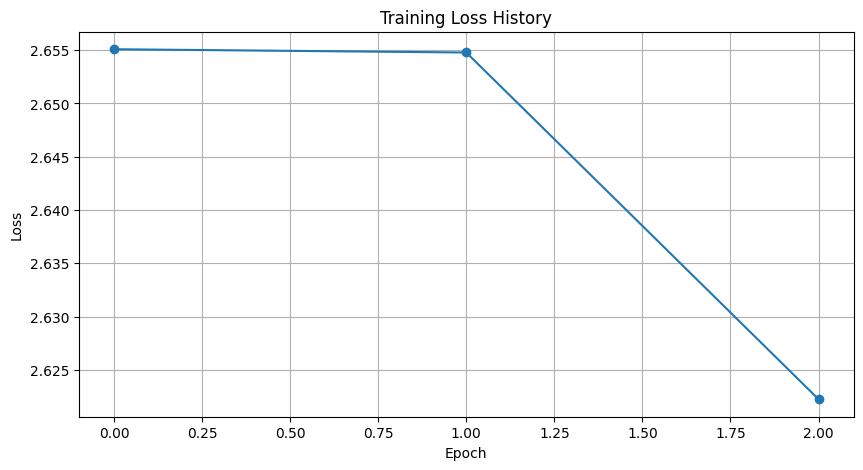

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

all_predictions = []
all_labels = []

model.eval()

with torch.no_grad():
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='macro')

print({'accuracy': accuracy, 'f1': f1})

{'accuracy': 0.04065040650406504, 'f1': 0.005580357142857143}


In [ ]:
print(dataset[0])

{'path': '/Users/shabiras/.cache/huggingface/datasets/downloads/extracted/9a8f65ee36486d6581eff211878926cb9479be49617cdd367da203ff3e7d0bb0/de-DE~CASH_DEPOSIT/response_4.wav', 'audio': {'path': '/Users/shabiras/.cache/huggingface/datasets/downloads/extracted/9a8f65ee36486d6581eff211878926cb9479be49617cdd367da203ff3e7d0bb0/de-DE~CASH_DEPOSIT/response_4.wav', 'array': array([-1.11991540e-07,  9.51089896e-06,  5.26400981e-07, ...,
        3.63070145e-03,  2.57458771e-03,  1.28283433e-03]), 'sampling_rate': 16000}, 'transcription': 'ich möchte gerne Geld auf mein Konto einzahlen', 'english_transcription': 'I would like to deposit money into my account', 'intent_class': 7, 'lang_id': 1}
